# Region Proposal
### DATASET :: NWPU-RESISC45
 * Only Using Air Planes
 * G. Cheng, J. Han, X. Lu. Remote Sensing Image Scene Classification: Benchmark and State of the Art. Proceedings of the IEEE.)
 * <http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html>

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import sys
import random
import pandas as pd

from matplotlib import patches
from tqdm.notebook import tqdm

ROOT_DIR = os.path.abspath('../')
sys.path.append(ROOT_DIR)

from module.dataset import Dataset
from module.utils import *


### 1. System Path Setting

In [2]:
DATA_NAME = 'air_planes'
DATA_DIR = os.path.join(ROOT_DIR, 'data', DATA_NAME)
IMG_DIR = os.path.join(DATA_DIR, 'images')
ANN_DIR = os.path.join(DATA_DIR, 'annotations')

### 2. LOAD DATASET

In [3]:
dataset = Dataset()
dataset.AddImage(IMG_DIR)
dataset.ParseAnnotations(ANN_DIR)

In [6]:
def RegionProposal(img, is_visible=False):
    # 1. Extract Candidate Region of Interest Using Selective Search
    rois = SelectiveSearch(img)

    # 2. GT correspond to image
    gt_bbox = dataset.annotations[img_file]
    
    # 3. Separate to Pos/Neg Region
    regions, deltas = SeparateToRegions(gt_bbox, rois, th=0.7)

    if is_visible:
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        DrawBoxes(img, gt_bbox, title='Ground Truth', ax=ax[0][0])
        DrawBoxes(img, rois, title='Candidate ROI', color='r', ax=ax[0][1])
        DrawBoxes(img, regions[np.where(regions[:,4] == 1)], title='Pos Regions', color='b', linestyle="-", ax=ax[1][0])
        DrawBoxes(img, regions[np.where(regions[:,4] == 0)], title='Neg Regions', color='c', linestyle="-", ax=ax[1][1])
        plt.tight_layout()
    
    return regions, deltas


### 3. Single Image Proposal Example

image_file:: airplane_180.jpg
Total Regions :: (94, 5)
Total Deltas :: (12, 4)


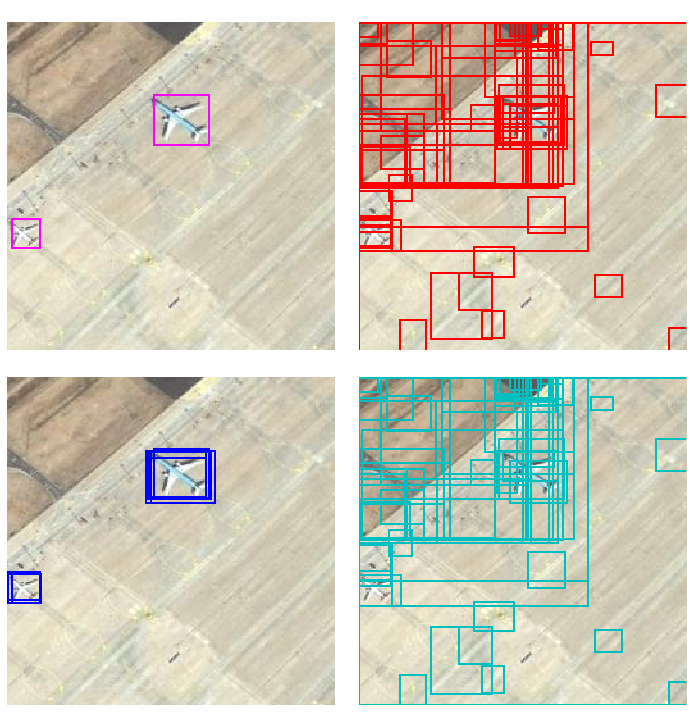

In [7]:
# image Load
# img_file = random.choice(list(dataset.images.values()))
img_file = dataset.images[32]
print('image_file::',img_file)
img = cv2.imread(os.path.join(IMG_DIR, img_file))
regions, deltas = RegionProposal(img, is_visible=True)
print('Total Regions ::', regions.shape)
print('Total Deltas ::', deltas.shape)

### 4. Overall Image Region Proposal and Save

In [8]:
cls_trn_img = np.array([], dtype=np.uint8).reshape(0, 224, 224, 3)
cls_trn_lb = np.array([], dtype=np.int32).reshape(0, 1)
reg_trn_img = np.array([], dtype=np.uint8).reshape(0, 224, 224, 3)
reg_trn_delta = np.array([], dtype=np.float32).reshape(0, 4)

for key in tqdm(dataset.images.keys()):
    img = cv2.imread(os.path.join(IMG_DIR, dataset.images[key]))
    regions, deltas = RegionProposal(img, is_visible=False)
    
    _cls_trn_img, _cls_trn_lb, _reg_trn_img, _reg_trn_delta = WarppingImage(img, regions, deltas)
    cls_trn_img = np.vstack([cls_trn_img, _cls_trn_img])
    cls_trn_lb = np.vstack([cls_trn_lb, _cls_trn_lb])
    reg_trn_img = np.vstack([reg_trn_img, _reg_trn_img])
    reg_trn_delta = np.vstack([reg_trn_delta, _reg_trn_delta])

# Save Region Proposal Data
save_path = os.path.join(ROOT_DIR, 'experiments/train_data.npz')
np.savez_compressed(save_path, cls_trn_img=cls_trn_img, cls_trn_lb=cls_trn_lb, reg_trn_img=reg_trn_img, reg_trn_delta=reg_trn_delta)

In [9]:
train_data = np.load(save_path)
print(train_data['cls_trn_img'].shape)
print(train_data['cls_trn_lb'].shape)
print(train_data['reg_trn_img'].shape)
print(train_data['reg_trn_delta'].shape)

(71082, 224, 224, 3)
(71082, 1)
(1524, 224, 224, 3)
(1524, 4)
